In [1]:
import os
import pathlib
import gc
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Define the directory of the dataset
data_dir = pathlib.Path('CatsDogs/')

# Remove corrupted files
os.system("rm CatsDogs/Cats/666.jpg CatsDogs/Dogs/11702.jpg CatsDogs/Dogs/11410.jpg")

# Collects the path of all the files within the dataset
data_paths = [str(path) for path in list(data_dir.glob("*/*.jpg"))]
print(f"Images in the dataset: {len(data_paths)}")

Images in the dataset: 24997


In [3]:
# Convert non-jpeg images into jpeg files
formats = [(path, Image.open(path).format) for path in data_paths]
non_jpegs = list(filter(lambda x: x[1]!='JPEG', formats))
for path, _ in non_jpegs:
    img = Image.open(path)
    img.convert('RGB').save(path, format='JPEG')

"# Convert non-jpeg images into jpeg files\nformats = [(path, Image.open(path).format) for path in data_paths]\nnon_jpegs = list(filter(lambda x: x[1]!='JPEG', formats))\nfor path, _ in non_jpegs:\n    img = Image.open(path)\n    img.convert('RGB').save(path, format='JPEG')"

In [4]:
# Create the respective tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices(data_paths)
# Shuffle the dataset
dataset = dataset.shuffle(len(data_paths), reshuffle_each_iteration=False)

2022-07-23 09:37:36.522807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 09:37:36.660725: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 09:37:36.661516: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-23 09:37:36.664561: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
# Get the class names
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if not item.name.startswith('.')]))
print(class_names)

['Cats' 'Dogs']


In [6]:
# Create a test set
test_size = int(len(list(dataset)) * 0.2)
train = dataset.skip(test_size)
test = dataset.take(test_size)

# Create a validation set
val_size = int(len(list(train)) * 0.2)
val = train.take(val_size)
train = train.skip(val_size)

In [7]:
# Set initial params for the loader
batch_size = 64
img_height = 256
img_width = 256

In [8]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [9]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [10]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
# Create a dataset of image, label pairs
train = train.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val = val.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [12]:
# Configure dataset for performance
def configure_for_performance(ds):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

train = configure_for_performance(train)
val = configure_for_performance(val)
test = configure_for_performance(test)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [14]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [15]:
n_epochs = 15

history = model.fit(
    train,
    validation_data=val,
    epochs=n_epochs
)

Epoch 1/15


2022-07-23 09:37:43.511867: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-23 09:37:50.366774: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 28/250 [==>...........................] - ETA: 1:16 - loss: 1.8687 - accuracy: 0.4989

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 1:13 - loss: 1.5582 - accuracy: 0.4992

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 63/250 [======>.......................] - ETA: 1:05 - loss: 1.2099 - accuracy: 0.5260

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 86/250 [=========>....................] - ETA: 57s - loss: 1.0639 - accuracy: 0.5520

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 46s - loss: 0.9534 - accuracy: 0.5744

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


125/250 [==============>...............] - ETA: 43s - loss: 0.9326 - accuracy: 0.5801

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


191/250 [=====================>........] - ETA: 20s - loss: 0.8311 - accuracy: 0.6040

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


195/250 [======================>.......] - ETA: 19s - loss: 0.8265 - accuracy: 0.6054

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


233/250 [==========================>...] - ETA: 5s - loss: 0.7936 - accuracy: 0.6143

250/250 [==============================] - ETA: 0s - loss: 0.7824 - accuracy: 0.6172

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 120s 428ms/step - loss: 0.7824 - accuracy: 0.6172 - val_loss: 0.6055 - val_accuracy: 0.6959
Epoch 2/15
 28/250 [==>...........................] - ETA: 30s - loss: 0.5822 - accuracy: 0.7098

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 29s - loss: 0.5845 - accuracy: 0.7089

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 25s - loss: 0.5743 - accuracy: 0.7173

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 24s - loss: 0.5670 - accuracy: 0.7209

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 19s - loss: 0.5591 - accuracy: 0.7247

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.5532 - accuracy: 0.7297

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.5395 - accuracy: 0.7371

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


195/250 [======================>.......] - ETA: 7s - loss: 0.5389 - accuracy: 0.7374

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 2s - loss: 0.5313 - accuracy: 0.7418

249/250 [============================>.] - ETA: 0s - loss: 0.5287 - accuracy: 0.7426

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 46s 178ms/step - loss: 0.5286 - accuracy: 0.7425 - val_loss: 0.5836 - val_accuracy: 0.7082
Epoch 3/15
 28/250 [==>...........................] - ETA: 31s - loss: 0.4503 - accuracy: 0.7896

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 29s - loss: 0.4399 - accuracy: 0.7977

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 26s - loss: 0.4357 - accuracy: 0.7988

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 23s - loss: 0.4189 - accuracy: 0.8071

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 18s - loss: 0.4132 - accuracy: 0.8098

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.4072 - accuracy: 0.8144

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.3835 - accuracy: 0.8274

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


195/250 [======================>.......] - ETA: 7s - loss: 0.3838 - accuracy: 0.8277

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 2s - loss: 0.3734 - accuracy: 0.8320

249/250 [============================>.] - ETA: 0s - loss: 0.3711 - accuracy: 0.8332

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 171ms/step - loss: 0.3708 - accuracy: 0.8333 - val_loss: 0.6156 - val_accuracy: 0.7234
Epoch 4/15
 28/250 [==>...........................] - ETA: 32s - loss: 0.2855 - accuracy: 0.8800

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 30s - loss: 0.2771 - accuracy: 0.8849

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 27s - loss: 0.2688 - accuracy: 0.8892

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 23s - loss: 0.2686 - accuracy: 0.8878

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 19s - loss: 0.2622 - accuracy: 0.8893

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.2574 - accuracy: 0.8921

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.2401 - accuracy: 0.9003

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


196/250 [======================>.......] - ETA: 7s - loss: 0.2394 - accuracy: 0.9007

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 2s - loss: 0.2304 - accuracy: 0.9056

249/250 [============================>.] - ETA: 0s - loss: 0.2277 - accuracy: 0.9066

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 170ms/step - loss: 0.2276 - accuracy: 0.9066 - val_loss: 0.8141 - val_accuracy: 0.7182
Epoch 5/15
 28/250 [==>...........................] - ETA: 30s - loss: 0.1460 - accuracy: 0.9498

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 31s - loss: 0.1415 - accuracy: 0.9507

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 27s - loss: 0.1381 - accuracy: 0.9512

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 23s - loss: 0.1334 - accuracy: 0.9513

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 19s - loss: 0.1325 - accuracy: 0.9527

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.1292 - accuracy: 0.9545

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.1282 - accuracy: 0.9545

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


196/250 [======================>.......] - ETA: 7s - loss: 0.1276 - accuracy: 0.9545

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 2s - loss: 0.1209 - accuracy: 0.9570

249/250 [============================>.] - ETA: 0s - loss: 0.1188 - accuracy: 0.9578

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 170ms/step - loss: 0.1187 - accuracy: 0.9577 - val_loss: 1.0444 - val_accuracy: 0.7274
Epoch 6/15
 28/250 [==>...........................] - ETA: 32s - loss: 0.0683 - accuracy: 0.9810

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 30s - loss: 0.0683 - accuracy: 0.9803

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 26s - loss: 0.0668 - accuracy: 0.9800

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 22s - loss: 0.0671 - accuracy: 0.9793

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 19s - loss: 0.0692 - accuracy: 0.9790

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.0698 - accuracy: 0.9787

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.0669 - accuracy: 0.9791

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


195/250 [======================>.......] - ETA: 7s - loss: 0.0668 - accuracy: 0.9791

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 2s - loss: 0.0634 - accuracy: 0.9807

250/250 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9811

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 169ms/step - loss: 0.0623 - accuracy: 0.9811 - val_loss: 1.2596 - val_accuracy: 0.7294
Epoch 7/15
 28/250 [==>...........................] - ETA: 30s - loss: 0.0367 - accuracy: 0.9894

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 29s - loss: 0.0401 - accuracy: 0.9881

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 25s - loss: 0.0376 - accuracy: 0.9895

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 22s - loss: 0.0370 - accuracy: 0.9901

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 18s - loss: 0.0423 - accuracy: 0.9879

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.0445 - accuracy: 0.9875

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.0448 - accuracy: 0.9874

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


195/250 [======================>.......] - ETA: 7s - loss: 0.0447 - accuracy: 0.9874

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 2s - loss: 0.0428 - accuracy: 0.9884

250/250 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9877

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 169ms/step - loss: 0.0442 - accuracy: 0.9877 - val_loss: 1.2456 - val_accuracy: 0.7224
Epoch 8/15
 28/250 [==>...........................] - ETA: 31s - loss: 0.0582 - accuracy: 0.9838

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 30s - loss: 0.0523 - accuracy: 0.9852

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 26s - loss: 0.0476 - accuracy: 0.9861

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 23s - loss: 0.0547 - accuracy: 0.9867

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 19s - loss: 0.0533 - accuracy: 0.9861

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.0529 - accuracy: 0.9859

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.0515 - accuracy: 0.9878

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


195/250 [======================>.......] - ETA: 7s - loss: 0.0514 - accuracy: 0.9879

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 2s - loss: 0.0479 - accuracy: 0.9884

249/250 [============================>.] - ETA: 0s - loss: 0.0466 - accuracy: 0.9886

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 171ms/step - loss: 0.0468 - accuracy: 0.9886 - val_loss: 1.4057 - val_accuracy: 0.7197
Epoch 9/15
 28/250 [==>...........................] - ETA: 30s - loss: 0.0417 - accuracy: 0.9877

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 28s - loss: 0.0392 - accuracy: 0.9893

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 25s - loss: 0.0312 - accuracy: 0.9919

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 22s - loss: 0.0265 - accuracy: 0.9937

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 18s - loss: 0.0305 - accuracy: 0.9935

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.0304 - accuracy: 0.9934

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.0293 - accuracy: 0.9934

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


195/250 [======================>.......] - ETA: 7s - loss: 0.0292 - accuracy: 0.9933

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


234/250 [===========================>..] - ETA: 2s - loss: 0.0315 - accuracy: 0.9930

250/250 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9929

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 168ms/step - loss: 0.0312 - accuracy: 0.9929 - val_loss: 1.5025 - val_accuracy: 0.7337
Epoch 10/15
 28/250 [==>...........................] - ETA: 30s - loss: 0.0271 - accuracy: 0.9922

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 29s - loss: 0.0227 - accuracy: 0.9938

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 25s - loss: 0.0205 - accuracy: 0.9944

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 22s - loss: 0.0194 - accuracy: 0.9944

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/250 [=============>................] - ETA: 18s - loss: 0.0230 - accuracy: 0.9940

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.0225 - accuracy: 0.9942

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.0226 - accuracy: 0.9941

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


196/250 [======================>.......] - ETA: 7s - loss: 0.0223 - accuracy: 0.9942

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 2s - loss: 0.0211 - accuracy: 0.9944

249/250 [============================>.] - ETA: 0s - loss: 0.0261 - accuracy: 0.9945

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 43s 166ms/step - loss: 0.0261 - accuracy: 0.9946 - val_loss: 1.5684 - val_accuracy: 0.7172
Epoch 11/15
 28/250 [==>...........................] - ETA: 36s - loss: 0.0399 - accuracy: 0.9911

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 33s - loss: 0.0380 - accuracy: 0.9897

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 27s - loss: 0.0324 - accuracy: 0.9902

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 23s - loss: 0.0348 - accuracy: 0.9908

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 19s - loss: 0.0347 - accuracy: 0.9896

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.0343 - accuracy: 0.9898

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.0317 - accuracy: 0.9909

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


195/250 [======================>.......] - ETA: 7s - loss: 0.0317 - accuracy: 0.9908

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 2s - loss: 0.0339 - accuracy: 0.9917

250/250 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.9921

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 169ms/step - loss: 0.0325 - accuracy: 0.9921 - val_loss: 1.5378 - val_accuracy: 0.7299
Epoch 12/15
 28/250 [==>...........................] - ETA: 30s - loss: 0.0250 - accuracy: 0.9911

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 28s - loss: 0.0262 - accuracy: 0.9910

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 26s - loss: 0.0210 - accuracy: 0.9941

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 22s - loss: 0.0178 - accuracy: 0.9955

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 18s - loss: 0.0193 - accuracy: 0.9953

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.0201 - accuracy: 0.9949

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.0192 - accuracy: 0.9953

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


195/250 [======================>.......] - ETA: 7s - loss: 0.0199 - accuracy: 0.9950

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 2s - loss: 0.0251 - accuracy: 0.9945

249/250 [============================>.] - ETA: 0s - loss: 0.0246 - accuracy: 0.9946

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 169ms/step - loss: 0.0251 - accuracy: 0.9946 - val_loss: 1.5545 - val_accuracy: 0.7187
Epoch 13/15
 28/250 [==>...........................] - ETA: 29s - loss: 0.0141 - accuracy: 0.9972

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 28s - loss: 0.0122 - accuracy: 0.9979

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 25s - loss: 0.0132 - accuracy: 0.9968

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 22s - loss: 0.0152 - accuracy: 0.9966

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 18s - loss: 0.0148 - accuracy: 0.9966

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.0142 - accuracy: 0.9969

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.0122 - accuracy: 0.9974

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


196/250 [======================>.......] - ETA: 7s - loss: 0.0121 - accuracy: 0.9974

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 2s - loss: 0.0194 - accuracy: 0.9969

249/250 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9969

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 169ms/step - loss: 0.0187 - accuracy: 0.9969 - val_loss: 1.6350 - val_accuracy: 0.7247
Epoch 14/15
 28/250 [==>...........................] - ETA: 32s - loss: 0.0152 - accuracy: 0.9961

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 30s - loss: 0.0150 - accuracy: 0.9963

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 25s - loss: 0.0135 - accuracy: 0.9961

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 22s - loss: 0.0133 - accuracy: 0.9957

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 18s - loss: 0.0120 - accuracy: 0.9965

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.0116 - accuracy: 0.9967

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.0112 - accuracy: 0.9971

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


195/250 [======================>.......] - ETA: 7s - loss: 0.0113 - accuracy: 0.9970

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 2s - loss: 0.0113 - accuracy: 0.9969

249/250 [============================>.] - ETA: 0s - loss: 0.0112 - accuracy: 0.9969

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 169ms/step - loss: 0.0111 - accuracy: 0.9969 - val_loss: 1.8333 - val_accuracy: 0.7167
Epoch 15/15
 28/250 [==>...........................] - ETA: 30s - loss: 0.0126 - accuracy: 0.9972

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


 38/250 [===>..........................] - ETA: 29s - loss: 0.0127 - accuracy: 0.9971

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


 64/250 [======>.......................] - ETA: 26s - loss: 0.0149 - accuracy: 0.9966

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


 87/250 [=========>....................] - ETA: 22s - loss: 0.0163 - accuracy: 0.9962

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/250 [============>.................] - ETA: 18s - loss: 0.0250 - accuracy: 0.9947

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


126/250 [==============>...............] - ETA: 17s - loss: 0.0244 - accuracy: 0.9948

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


192/250 [======================>.......] - ETA: 8s - loss: 0.0215 - accuracy: 0.9952

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


196/250 [======================>.......] - ETA: 7s - loss: 0.0213 - accuracy: 0.9953

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


235/250 [===========================>..] - ETA: 2s - loss: 0.0210 - accuracy: 0.9950

249/250 [============================>.] - ETA: 0s - loss: 0.0207 - accuracy: 0.9951

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


250/250 [==============================] - 44s 170ms/step - loss: 0.0206 - accuracy: 0.9951 - val_loss: 1.7472 - val_accuracy: 0.7132


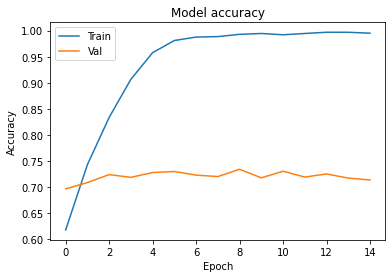

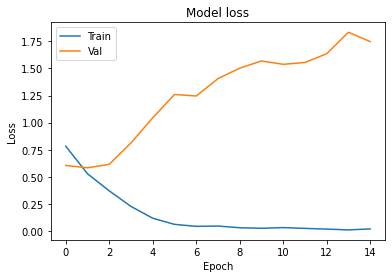

In [16]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

plot_history(history)

In [17]:
def zero_one_loss(dataset, dataset_size):
    
    _, accuracy = model.evaluate(dataset)
    zero_one_loss = dataset_size*(1-accuracy)

    return int(round(zero_one_loss, ndigits=0))

In [18]:
print(f"Zero-one loss on the test set: {zero_one_loss(test, test_size)}")

42/79 [==============>...............] - ETA: 13s - loss: 1.7578 - accuracy: 0.7132

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


43/79 [===============>..............] - ETA: 12s - loss: 1.7487 - accuracy: 0.7155

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


56/79 [====================>.........] - ETA: 8s - loss: 1.7934 - accuracy: 0.7115

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


79/79 [==============================] - 28s 282ms/step - loss: 1.7785 - accuracy: 0.7071
Zero-one loss on the test set: 1464


In [19]:
# Clear any previous state
del model
tf.keras.backend.clear_session()
gc.collect()

7340

# K-fold cross validation

In [20]:
from sklearn.model_selection import KFold


k_fold = KFold(n_splits=5)
k_splits = k_fold.split(data_paths)
results = []
zero_one_losses = []

for train_index, test_index in k_splits:

    # Get the paths to the data
    train_paths = np.asarray(data_paths)[train_index]
    test_paths = np.asarray(data_paths)[test_index]

    # Make it tf.data.Dataset
    train = tf.data.Dataset.from_tensor_slices(train_paths)
    test = tf.data.Dataset.from_tensor_slices(test_paths)

    # Shuffle the dataset
    train = train.shuffle(len(train))
    test = test.shuffle(len(test))
    
    # Get labels
    train = train.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    test = test.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Configure for performance
    train = configure_for_performance(train)
    test = configure_for_performance(test)

    # Create the model
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(16, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
    
    model.fit(
        train,
        epochs=n_epochs,
        verbose=0
    )
    
    zero_one_losses.append(zero_one_loss(test, len(test_index)))
    
    # Clear any previous state
    del model
    tf.keras.backend.clear_session()
    gc.collect()

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 

21/79 [======>.......................] - ETA: 6s - loss: 2.1543 - accuracy: 0.6875

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


57/79 [====================>.........] - ETA: 2s - loss: 2.2553 - accuracy: 0.6856

61/79 [======================>.......] - ETA: 2s - loss: 2.2582 - accuracy: 0.6847

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


79/79 [==============================] - 9s 94ms/step - loss: 2.2634 - accuracy: 0.6824


Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


20/79 [======>.......................] - ETA: 6s - loss: 2.2357 - accuracy: 0.6680

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


50/79 [=================>............] - ETA: 3s - loss: 2.2617 - accuracy: 0.6694

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


57/79 [====================>.........] - ETA: 2s - loss: 2.3100 - accuracy: 0.6669

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


60/79 [=====================>........] - ETA: 2s - loss: 2.2966 - accuracy: 0.6693

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


79/79 [==============================] - 9s 92ms/step - loss: 2.2957 - accuracy: 0.6692


Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker

 1/79 [..............................] - ETA: 2:18 - loss: 0.9995 - accuracy: 0.8281

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


19/79 [======>.......................] - ETA: 9s - loss: 1.3904 - accuracy: 0.7747

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


58/79 [=====================>........] - ETA: 2s - loss: 1.4892 - accuracy: 0.7567

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


79/79 [==============================] - 11s 116ms/step - loss: 1.5123 - accuracy: 0.7550


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0

47/79 [================>.............] - ETA: 4s - loss: 3.3115 - accuracy: 0.6263

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


79/79 [==============================] - 11s 114ms/step - loss: 3.3497 - accuracy: 0.6275


Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd

 2/79 [..............................] - ETA: 10s - loss: 2.1714 - accuracy: 0.6875 

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


79/79 [==============================] - 11s 114ms/step - loss: 2.2404 - accuracy: 0.6657


In [21]:
mean_loss = np.round(np.mean(zero_one_losses), decimals=0)
std_loss = np.round(np.std(zero_one_losses), decimals=0)
print(f'The mean of zero-one loss is {int(mean_loss)}, with a standard deviation of {int(std_loss)} missmatched samples')

The mean of zero-one loss is 1600, with a standard deviation of 209 missmatched samples
